           CRIM          ZN      INDUS      CHAS       NOX        RM  \
mean   3.611874   11.211934  11.083992  0.069959  0.554695  6.284634   
std    8.720192   23.388876   6.835896  0.255340  0.115878  0.702617   
min    0.006320    0.000000   0.460000  0.000000  0.385000  3.561000   
max   88.976200  100.000000  27.740000  1.000000  0.871000  8.780000   

             AGE        DIS        RAD         TAX    PTRATIO           B  \
mean   68.518519   3.795043   9.549407  408.237154  18.455534  356.674032   
std    27.999513   2.105710   8.707259  168.537116   2.164946   91.294864   
min     2.900000   1.129600   1.000000  187.000000  12.600000    0.320000   
max   100.000000  12.126500  24.000000  711.000000  22.000000  396.900000   

          LSTAT       MEDV  
mean  12.715432  22.532806  
std    7.155871   9.197104  
min    1.730000   5.000000  
max   37.970000  50.000000  


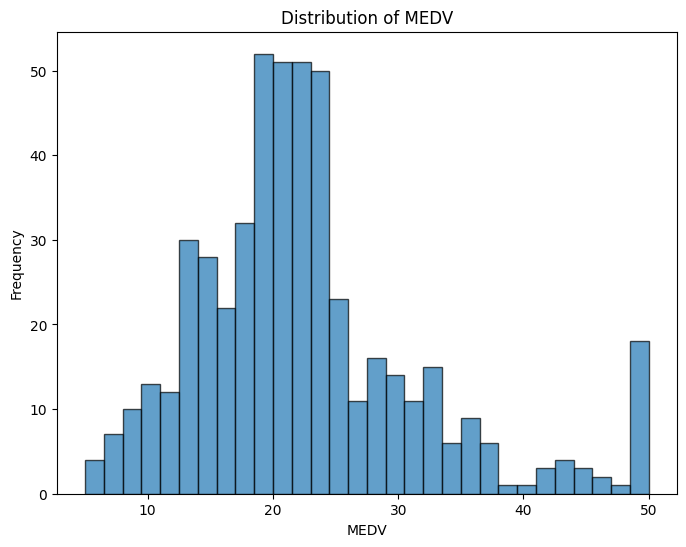

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
import numpy as np

#-------Load the dataset and Print the statistics-------------
housing_data = pd.read_csv("HousingData.csv")
statistics = housing_data.agg(['mean', 'std', 'min', 'max'])
print(statistics)

#---a graph that shows the distribution of the various labels across the entire dataset----
housing_medv = housing_data['MEDV']

plt.figure(figsize=(8, 6))
plt.hist(housing_medv, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('MEDV')
plt.ylabel('Frequency')
plt.title('Distribution of MEDV')
plt.show()

#---------Split the data into train (70%), validation (15%), and test (15%) sets--------
X = housing_data.drop(columns=['MEDV'])
y = housing_data['MEDV']
y=np.array(y)
y = y[:, np.newaxis]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#-------------------Normalise and standarize the data------------------
# Handle missing data (if any)
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)
X_test = imputer.transform(X_test)

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_val_normalized = scaler.transform(X_val)
X_test_normalized = scaler.transform(X_test)

# Standardize the data (mean=0, std=1) using Z-score scaling
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_val_standardized = scaler.transform(X_val)
X_test_standardized = scaler.transform(X_test)

In [2]:
import wandb
import numpy as np

class MLPRegressor:
    def __init__(self, num_hidden_layers=1, num_neurons=64, activation='relu', learning_rate=0.01):
        self.num_hidden_layers = num_hidden_layers
        self.num_neurons = num_neurons
        self.activation = activation
        self.learning_rate = learning_rate
        self.weights = []
        self.biases = []
        self.activations = [self.activation] * (num_hidden_layers + 1)
        self.activations[-1] = 'linear'  # Use linear activation for regression

    def initialize_weights_and_biases(self, input_dim):
        layer_sizes = [input_dim] + [self.num_neurons] * self.num_hidden_layers + [1]  # Regression has one output
        for i in range(1, len(layer_sizes)):
            input_size, output_size = layer_sizes[i - 1], layer_sizes[i]
            weight = np.random.randn(input_size, output_size) * 0.01
            bias = np.zeros((1, output_size))
            self.weights.append(weight)
            self.biases.append(bias)

    def compute_loss(self, y_true, y_pred):
        m = len(y_true)
        loss = 0.5 * np.mean((y_true - y_pred) ** 2)
        return loss

    def activate(self, x, activation_type):
        if activation_type == 'relu':
            return np.maximum(0, x)
        elif activation_type == 'sigmoid':
            x = np.clip(x, -500, 500)
            return 1 / (1 + np.exp(-x))
        elif activation_type == 'tanh':
            return np.tanh(x)
        elif activation_type == 'linear':
            return x

    def d_relu(self, x):
        return np.where(x > 0, 1, 0)

    def d_sigmoid(self, x):
        return x * (1 - x)

    def d_tanh(self, x):
        return 1 - np.tanh(x) ** 2
    
    def d_linear(self, x):
        return np.ones_like(x)

    def forward_propagation(self, x):
        z_values = []
        a_values = [x]
        for i in range(self.num_hidden_layers):
            z = np.dot(a_values[i], self.weights[i]) + self.biases[i]
            a = self.activate(z, self.activations[i])
            z_values.append(z)
            a_values.append(a)

        # Output layer with linear activation for regression
        z = np.dot(a_values[-1], self.weights[-1]) + self.biases[-1]
        a = self.activate(z, self.activations[-1])
        z_values.append(z)
        a_values.append(a)

        return z_values, a_values

    def backward_propagation(self, x, y):
        m = x.shape[0]
        z_values, a_values = self.forward_propagation(x)
        gradients = [None] * (self.num_hidden_layers + 1)

        # Compute gradient of the output layer
        gradients[-1] = (a_values[-1] - y) / m

        # Backpropagate through hidden layers
        for i in reversed(range(self.num_hidden_layers)):
            if self.activations[i] == 'relu':
                gradients[i] = np.dot(gradients[i + 1], self.weights[i + 1].T) * self.d_relu(a_values[i + 1])
            elif self.activations[i] == 'sigmoid':
                gradients[i] = np.dot(gradients[i + 1], self.weights[i + 1].T) * self.d_sigmoid(a_values[i + 1])
            elif self.activations[i] == 'tanh':
                gradients[i] = np.dot(gradients[i + 1], self.weights[i + 1].T) * self.d_tanh(a_values[i + 1])
            elif self.activations[i] == 'linear':
                gradients[i] = np.dot(gradients[i + 1], self.weights[i + 1].T) * self.d_linear(a_values[i + 1])

        # Compute gradients for weights and biases
        dW = [None] * (self.num_hidden_layers + 1)
        db = [None] * (self.num_hidden_layers + 1)
        for i in range(self.num_hidden_layers + 1):
            dW[i] = np.dot(a_values[i].T, gradients[i])
            db[i] = np.sum(gradients[i], axis=0)

        return dW, db

    def predict(self, x):
        _, y_pred = self.forward_propagation(x)
        return y_pred[-1]

    def sgd(self, x, y, num_epochs=1000):
        input_dim = x.shape[1]
        self.initialize_weights_and_biases(input_dim)

        m = x.shape[0]  # Number of training samples

        for epoch in range(num_epochs):
            for i in range(m):
                # Select a random training sample (Stochastic Gradient Descent)
                random_index = np.random.randint(0, m)
                x_sample = x[random_index:random_index + 1]
                y_sample = y[random_index:random_index + 1]

                dW, db = self.backward_propagation(x_sample, y_sample)

                for j in range(self.num_hidden_layers + 1):
                    self.weights[j] -= self.learning_rate * dW[j]
                    self.biases[j] -= self.learning_rate * db[j]

                _, y_pred = self.forward_propagation(x)
                loss = self.compute_loss(y, y_pred[-1])
                wandb.log({f"Loss Optimizer=SGD Epochs={num_epochs} Learning Rate={self.learning_rate} Num_hidden_layers={self.num_hidden_layers} Num_neurons={self.num_neurons} Activation={self.activation}": loss})

            if (epoch + 1) % 100 == 0:
                print(f"SGD Epoch {epoch + 1}/{num_epochs}, Loss: {loss:.4f}")

        print("SGD Training complete!")
        
    def batch_gradient_descent(self, x, y, batch_size=32, num_epochs=1000):
        input_dim = x.shape[1]
        self.initialize_weights_and_biases(input_dim)
        
        m = x.shape[0]  # Number of training samples
        
        for epoch in range(num_epochs):
            for i in range(0, m, batch_size):
                x_batch = x[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                
                dW, db = self.backward_propagation(x_batch, y_batch)
                
                for j in range(self.num_hidden_layers + 1):
                    self.weights[j] -= self.learning_rate * dW[j]
                    self.biases[j] -= self.learning_rate * db[j]
            
            _, y_pred = self.forward_propagation(x)
            loss = self.compute_loss(y, y_pred[-1])
            wandb.log({f"Loss Optimizer=Batch Epochs={num_epochs} Learning Rate={self.learning_rate} Num_hidden_layers={self.num_hidden_layers} Num_neurons={self.num_neurons} Activation={self.activation}": loss})
            
            if (epoch + 1) % 100 == 0:
                print(f"Batch Epoch {epoch + 1}/{num_epochs}, Loss: {loss:.4f}")
        
        print("Batch Training complete!")

    def mini_batch_gradient_descent(self, x, y, batch_size=32, num_epochs=1000):
        input_dim = x.shape[1]
        self.initialize_weights_and_biases(input_dim)
        
        m = x.shape[0]  # Number of training samples
        
        for epoch in range(num_epochs):
            indices = np.arange(m)
            np.random.shuffle(indices)
            x_shuffled = x[indices]
            y_shuffled = y[indices]
            
            for i in range(0, m, batch_size):
                x_batch = x_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                
                dW, db = self.backward_propagation(x_batch, y_batch)
                
                for j in range(self.num_hidden_layers + 1):
                    self.weights[j] -= self.learning_rate * dW[j]
                    self.biases[j] -= self.learning_rate * db[j]
            
            _, y_pred = self.forward_propagation(x)
            loss = self.compute_loss(y, y_pred[-1])
            wandb.log({f"Loss Optimizer=Mini_Batch Epochs={num_epochs} Learning Rate={self.learning_rate} Num_hidden_layers={self.num_hidden_layers} Num_neurons={self.num_neurons} Activation={self.activation}": loss})
            
            if (epoch + 1) % 100 == 0:
                print(f"Mini_Batch Epoch {epoch + 1}/{num_epochs}, Loss: {loss:.4f}")
        
        print("Mini_Batch Training complete!")
    
    def evaluate_model(self,x,y):
        _, y_pred = self.forward_propagation(x)
        loss = self.compute_loss(y, y_pred[-1])
        wandb.log({f"Loss Optimizer=Mini_Batch Learning Rate={self.learning_rate} Num_hidden_layers={self.num_hidden_layers} Num_neurons={self.num_neurons} Activation={self.activation}": loss})

In [35]:
from itertools import product
from sklearn.metrics import mean_squared_error, r2_score
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from prettytable import PrettyTable
from sklearn.metrics import classification_report


# Initialize and train the model
wandb.init(project="regression_example", entity="ashishchokhani2910")
best_mse = float('inf')
best_model = None
best_hyperparameters = None

# Define hyperparameters to tune
learning_rates = [0.01, 0.001]
num_epochs = [500, 1000]
num_hidden_layers = [1, 2]
num_neurons = [64, 128]
activations = ['relu', 'sigmoid','tanh']
optimizers = ['sgd', 'batch_gradient_descent', 'mini_batch_gradient_descent']

# # Define hyperparameters to tune
# learning_rates = [0.01]
# num_epochs = [1000]
# num_hidden_layers = [2]
# num_neurons = [5]
# activations = ['sigmoid']
# optimizers = ['sgd']

metrics_table = PrettyTable()
metrics_table.field_names = ["Learning Rate", "Number of Epochs", "Number of Hidden Layers", "Number of Neurons", "Activation Function", "Optimizer","MSE","RMSE","R-Squared"]


# Initialize a dictionary to collect metrics and hyperparameters
hyperparameter_metrics = {
    'learning_rate': [],
    'num_epochs': [],
    'num_hidden_layers': [],
    'num_neurons': [],
    'activation': [],
    'optimizer': [],
    'MSE': [],
    'RMSE': [],
    'R2': [],
}

# Perform hyperparameter tuning
for lr, epochs, num_layers, num_neurons, activation, optimizer in product(learning_rates, num_epochs, num_hidden_layers, num_neurons, activations, optimizers):
    
    config = {
        'learning_rate': lr,
        'num_epochs': epochs,
        'num_hidden_layers': num_layers,
        'num_neurons': num_neurons,
        'activation': activation,
        'optimizer': optimizer
    }
    wandb.config.update(config)

    model = MLPRegressor(
        num_hidden_layers=num_layers,
        num_neurons=num_neurons,
        activation=activation,
        learning_rate=lr,
    )
    model.sgd(X_train_standardized, y_train, num_epochs=epochs)
    model.evaluate_model(X_val_standardized,y_val)
    y_pred_val = model.predict(X_val_standardized)
    
    #Calculate and report metrics
    mse = mean_squared_error(y_val, y_pred_val)
    rmse = math.sqrt(mse)
    r2 = r2_score(y_val, y_pred_val)
    
    if mse < best_mse:  # We want to minimize MSE
        best_mse = mse
        best_model = model
        best_hyperparameters = {
            'learning_rate': lr,
            'num_epochs': epochs,
            'num_hidden_layers': num_layers,
            'num_neurons': num_neurons,
            'activation': activation,
            'optimizer': optimizer
        }
        
    metrics_table.add_row([lr, epochs, num_layers, num_neurons, activation, optimizer, mse, rmse, r2])
    
    hyperparameter_metrics['learning_rate'].append(lr)
    hyperparameter_metrics['num_epochs'].append(epochs)
    hyperparameter_metrics['num_hidden_layers'].append(num_layers)
    hyperparameter_metrics['num_neurons'].append(num_neurons)
    hyperparameter_metrics['activation'].append(activation)
    hyperparameter_metrics['optimizer'].append(optimizer)
    hyperparameter_metrics['MSE'].append(mse)
    hyperparameter_metrics['RMSE'].append(rmse)
    hyperparameter_metrics['R2'].append(r2)


print("Hyperparameters for the Best Model:")
for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")

print(metrics_table)

y_pred_test = best_model.predict(X_test_standardized)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = math.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)
report = f"MSE: {mse_test:.4f}\nRMSE: {rmse_test:.4f}\nR-squared: {r2_test:.4f}"

print("Regression Metrics on Test Set:")
print(report)


# Finish the W&B run
wandb.run.finish()


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Loss Optimizer=Mini_Batch Learning Rate=0.01 Num_hidden_layers=2 Num_neurons=5 Activation=sigmoid,▁
Loss Optimizer=SGD Epochs=1000 Learning Rate=0.01 Num_hidden_layers=2 Num_neurons=5 Activation=sigmoid,█▅▄▂▂▃▂▂▂▃▃▄▂▂▂▂▁▁▁▁▁▁▁▃▃▃▃▃▃▂▃▃▃▂▃▂▃▂▃▂
Loss Optimizer=Mini_Batch Learning Rate=0.01 Num_hidden_layers=2 Num_neurons=5 Activation=sigmoid,5.06754
Loss Optimizer=SGD Epochs=1000 Learning Rate=0.01 Num_hidden_layers=2 Num_neurons=5 Activation=sigmoid,5.39037


SGD Epoch 100/1000, Loss: 4.4626
SGD Epoch 200/1000, Loss: 3.7785
SGD Epoch 300/1000, Loss: 3.5614
SGD Epoch 400/1000, Loss: 3.6114
SGD Epoch 500/1000, Loss: 3.9872
SGD Epoch 600/1000, Loss: 3.6247
SGD Epoch 700/1000, Loss: 3.3578
SGD Epoch 800/1000, Loss: 3.3101
SGD Epoch 900/1000, Loss: 3.0701
SGD Epoch 1000/1000, Loss: 3.2146
SGD Training complete!
Hyperparameters for the Best Model:
learning_rate: 0.01
num_epochs: 1000
num_hidden_layers: 2
num_neurons: 5
activation: sigmoid
optimizer: sgd
+---------------+------------------+-------------------------+-------------------+---------------------+-----------+--------------------+-------------------+--------------------+
| Learning Rate | Number of Epochs | Number of Hidden Layers | Number of Neurons | Activation Function | Optimizer |        MSE         |        RMSE       |     R-Squared      |
+---------------+------------------+-------------------------+-------------------+---------------------+-----------+--------------------+-------

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Loss Optimizer=Mini_Batch Learning Rate=0.01 Num_hidden_layers=2 Num_neurons=5 Activation=sigmoid,▁
Loss Optimizer=SGD Epochs=1000 Learning Rate=0.01 Num_hidden_layers=2 Num_neurons=5 Activation=sigmoid,█▅▄▃▂▂▂▂▂▂▂▂▂▂▁▂▂▃▄▁▁▂▃▂▂▂▁▂▂▂▁▁▁▁▂▁▁▁▁▁
Loss Optimizer=Mini_Batch Learning Rate=0.01 Num_hidden_layers=2 Num_neurons=5 Activation=sigmoid,6.31705
Loss Optimizer=SGD Epochs=1000 Learning Rate=0.01 Num_hidden_layers=2 Num_neurons=5 Activation=sigmoid,3.21456


## W&B report for above hyperparameters

https://wandb.ai/ashishchokhani2910/q3/reports/Performance-of-MLP-on-Regression--Vmlldzo1NzU2Mjc3